In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.autograd import Variable

import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [3]:
# store the path to the directories with preprocessed png images
train_dir = '../input/siic-isic-224x224-images/train/'
test_dir = '../input/siic-isic-224x224-images/test/'

# load csv files with image name and metadata
train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

### Create Dataset and DataLoader

In [4]:
# set device to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Dataset and the DataLoader
class MyDataset(Dataset):
    def __init__(self, dataframe, train=True, transform=None):
        self.df = dataframe
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df['image_name'][idx]
        
        if self.train:
            img_path = train_dir + img_name + '.png'
        else:
            img_path = test_dir + img_name + '.png'
        
        # read in the image
        image = cv2.imread(img_path) # (224, 224, 3)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # reorder colors
        image = transforms.ToPILImage()(image) 
            
        if self.transform:
            image = self.transform(image)
          
        if self.train:
            label = self.df['target'][idx]
            return image, label
        else:
            return image

# do some data augmentation
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = MyDataset(train_df, train=True, transform=data_transform)
testset = MyDataset(test_df, train=False, transform=test_transform)

### Define a multilayer neural net

In [5]:
def train(epoch, train_loader, verbose=True):
    network.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())   # add the loss of each batch
    return losses

def test(train_loader):
    network.eval()
    test_loss = 0
    correct = 0
    probs = np.zeros((len(trainset, )))
    targets = np.zeros((len(trainset, )))
    
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        prob = F.softmax(output, 1)[:, 1].cpu().detach().numpy()
        probs[i*batch_size:(i+1)*batch_size] = prob
        targets[i*batch_size:(i+1)*batch_size] = target.cpu().detach().numpy()

    test_loss /= len(train_loader.dataset)
    
    roc = roc_auc_score(targets, probs)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), AUROC: {:.4f}\n'.format(
        test_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset), roc))
    return test_loss, 100. * correct / len(train_loader.dataset), roc

In [6]:
num_inputs = 150528 # 3 x 224 x 224 color images
num_outputs = 2

class MultiLayerNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units):
        super(MultiLayerNet, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_units)
        self.linear2 = nn.Linear(hidden_units, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs)
        output = self.linear1(input)
        output = torch.tanh(output)
        output = self.linear2(output)
        return output
    
##########################################################

class ConvolutionalNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) # 3 channel, 16 feature maps, 5x5 square convolution
        self.conv2 = nn.Conv2d(16, 128, 5) # 16 input, 128 output, 5x5 square convolution
        
        self.linear1 = nn.Linear(128 * 53 * 53, 64)  # 64 hidden units
        self.linear2 = nn.Linear(64, num_outputs)  # 64 hidden units to 10 output units

    def forward(self, input):
        output = F.tanh(self.conv1(input))
        output = F.max_pool2d(output, (2, 2))   # 2 by 2 max pooling (subsampling) 
        output = F.tanh(self.conv2(output))
        output = F.max_pool2d(output, (2, 2))   # 2 by 2 max pooling (subsampling) 
        
        # flatten to vector
        output = output.view(-1, self.num_flat_features(output)) # flatten features
        output = self.linear1(output)
        output = F.tanh(output)
        output = self.linear2(output)
        return output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
# input = torch.Size([64, 3, 224, 224])
# after conv1 = torch.Size([64, 16, 220, 220])
# after max_pooling = torch.Size([64, 16, 110, 110])
# after conv2 = torch.Size([64, 128, 106, 106])
# after max_pooling = torch.Size([64, 128, 53, 53])
# after flattening = torch.Size([64, 359552])

##########################################################

# Use Google's Inception V3 for pretraining and then finetune

class InceptionNet(nn.Module):
    pass

In [7]:
# Create a CNN based off of LeNet
class LeNet(nn.Module):
    pass

In [8]:
network = ConvolutionalNet(num_inputs, num_outputs)
print(network)

ConvolutionalNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=359552, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=2, bias=True)
)


### Train the neural network model

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 0 [0/33126 (0%)]	Loss: 0.684505
Train Epoch: 0 [6400/33126 (19%)]	Loss: 0.019103
Train Epoch: 0 [12800/33126 (39%)]	Loss: 0.099465
Train Epoch: 0 [19200/33126 (58%)]	Loss: 0.145902
Train Epoch: 0 [25600/33126 (77%)]	Loss: 0.020301
Train Epoch: 0 [32000/33126 (97%)]	Loss: 0.084840
Train Epoch: 1 [0/33126 (0%)]	Loss: 0.018834
Train Epoch: 1 [6400/33126 (19%)]	Loss: 0.019695
Train Epoch: 1 [12800/33126 (39%)]	Loss: 0.023133
Train Epoch: 1 [19200/33126 (58%)]	Loss: 0.065995
Train Epoch: 1 [25600/33126 (77%)]	Loss: 0.174024
Train Epoch: 1 [32000/33126 (97%)]	Loss: 0.017849
Train Epoch: 2 [0/33126 (0%)]	Loss: 0.081930
Train Epoch: 2 [6400/33126 (19%)]	Loss: 0.074008
Train Epoch: 2 [12800/33126 (39%)]	Loss: 0.079478
Train Epoch: 2 [19200/33126 (58%)]	Loss: 0.233191
Train Epoch: 2 [25600/33126 (77%)]	Loss: 0.028502
Train Epoch: 2 [32000/33126 (97%)]	Loss: 0.076702
Train Epoch: 3 [0/33126 (0%)]	Loss: 0.079376
Train Epoch: 3 [6400/33126 (19%)]	Loss: 0.082747
Train Epoch: 3 [12800/33

Text(0.5, 1.0, 'Training Loss over Epochs')

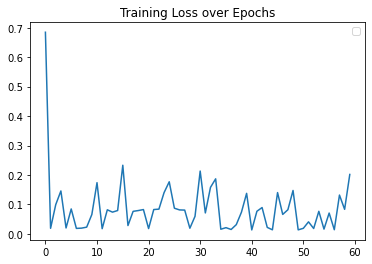

In [9]:
%%time

batch_size = 64
img_size = (224, 224)
epochs = 20       # number of epochs to train
lr = 0.001        # learning rate, 1e-2

# load data
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

# reset model
# network = MultiLayerNet(num_inputs, num_outputs, hidden_units=1000)
network = ConvolutionalNet(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    network.cuda()

train_losses = []
for epoch in range(epochs):
    train_loss = train(epoch, train_loader)
    train_losses += train_loss

# display the decreasing training loss
plt.plot(train_losses)
# test_loss, test_acc = test(test_loader)  # print the validation error
# plt.hlines(test_loss, 0, len(train_losses), color='r', label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training Loss over Epochs')

### Make predictions for the test data

In [10]:
%%time

# make evaluations on all the training data
test_loss, test_acc, test_roc = test(train_loader)  # print the validation error


Test set: Average loss: 0.0791, Accuracy: 32543/33126 (98%), AUROC: 0.8127

CPU times: user 10.3 s, sys: 5.13 s, total: 15.4 s
Wall time: 1min 39s


In [11]:
def predict(test_loader):
    network.eval()
    
    probs = np.zeros((len(testset, )))
    preds = np.zeros((len(testset, )))
    for i, data in enumerate(test_loader):  # return each batch
        data = data.to(device)
        
        output = network(data)
    
        prob = F.softmax(output, 1)[:, 1].cpu().detach().numpy()
        pred = output.data.max(1, keepdim=True)[1].flatten().cpu().detach().numpy() # get the index of the max log-probability
        
        probs[i*batch_size:(i+1)*batch_size] = prob
        preds[i*batch_size:(i+1)*batch_size] = pred
        
    return probs, preds    

In [12]:
# predict for the test_values
probs, preds = predict(test_loader)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [13]:
# write to file
test = pd.DataFrame({'image_name': test_df['image_name'], 'target': probs})

test.to_csv('cnn.csv', index=False)

### Store Trained Model

In [14]:
# save the model
PATH = "cnn.pt"
torch.save(network.state_dict(), PATH)  # we only save the state_dict rather than entire model

In [15]:
# load the model and use for evaluation
network = MultiLayerNet(num_inputs, num_outputs, hidden_units=1000)
#model.load_state_dict("../output/" + torch.load(PATH)) 
network.load_state_dict(torch.load("../input/multilayer-model/multilayer.pt")) 
network.eval()  # set dropout and batch normalization layers to evaluation before running inference

MultiLayerNet(
  (linear1): Linear(in_features=150528, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=2, bias=True)
)

### Predicting for a Single Image

In [16]:
def predict_single_image(image):
    """Given an image, predict benign or malignant """
    network.eval()
    
    for i, data in enumerate(test_loader):  # return each batch
        output = network(data)
    
        prob = F.softmax(output)[:, 1].item()
        pred = output.data.max(1, keepdim=True)[1].flatten().item() # get the index of the max log-probability
        
    return prob, pred